# Sentence Splitting
This notebook uses OCRed text for a volume year and splits it into sentences using regular expression pattern matching.<br>
For this notebook to run, there should be an OCRed folder that should contain a .txt file, a .tsv file, and an images sub-folder (more details in the notebook).

This notebook mirrors `sentence_splitting.ipynb`, but has explainations along with the code.

<b>Note:</b>
- If the Acts and Joints were mixed for the chosen year, the OCRed output will contain `{year}_Both.txt` and `{year}_Both_data.tsv`
- If the Acts and Joints were seperate for the chosen year, the OCRed output will contain `{year}_Acts.txt` and `{year}_Acts_data.tsv`

In [1]:
from nltk.tokenize import PunktSentenceTokenizer
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
import re
from numpy import nan, where
# pd.set_option('display.max_colwidth', None)

<br>
Either get the year variable from elsewhere (such as when this notebook is accessed from another file) or specify the year.

In [2]:
# Get the year variable from somewhere else
%store -r year

In [3]:
# # If running this notebook independently,
# # Uncoment the following line of code
year = '1901'

In [4]:
# This is the directory that will contain the OCRed output:
dir_OCR = "/work/otb-lab/OCRed/" + str(year)

print(f"Working on {year} under {dir_OCR}")

Working on 1901 under /work/otb-lab/OCRed/1901


Since this file will be run in a batch, it is possible that the variables are cached to decrease run time. So, delete the `acts_path` variable if it exists.

In [5]:
if 'acts_path' in globals():
    print("Deleting acts_path")
    del acts_path

The OCR folders might contain many variations of the file that needs to be used here. Hence, the many if else statements.

In [6]:
# Try reading in "{year}_text.txt" if the Acts and Joints were seperate for the year
try:
    # Try to get a filename in the directory which has 'act' and 'text' in it
    for file in listdir(dir_OCR):
        
        if "txt" in file.lower() and "joint" not in file.lower() and "concurrent" not in file.lower() and "bills" not in file.lower():
            if "acts" in file.lower():
                acts_path = dir_OCR + "/" + file
                break
                
            elif "act" in file.lower():
                acts_path = dir_OCR + "/" + file
                break
    
    print(acts_path)
    with open(acts_path, 'r') as f:
        data = f.read()

    # If the read is successful, set a flag that identifies that the Acts and Joints are seperate
    actsSep = True

# However, if the directory contains {year}_Both.txt instead, a FileNotFoundError will be returned for the above code.
# So, catch that error and read in "{year}_Both.txt"
except:
    
    try:
    
    
        # Try to get a filename in the directory which has 'both' and 'text' in it
        for file in listdir(dir_OCR):

            if "both" in file.lower() and "txt" in file.lower() and "joint" not in file.lower() and "concurrent" not in file.lower() and "bills" not in file.lower():
                acts_path = dir_OCR + "/" + file

        print(acts_path)
        with open(acts_path, 'r') as f:
            data = f.read()

        actsSep = False  # The flag being False means that the Acts and Joints are not seperate
        
        
    # However, some years might contain {year}_Acts_Joints.txt
    except:
        
        # Try to get a filename in the directory which has 'both' and 'text' in it
        for file in listdir(dir_OCR):

            if "acts" in file.lower() and "joints" in file.lower() and "txt" in file.lower():
                acts_path = dir_OCR + "/" + file

        print(acts_path)
        with open(acts_path, 'r') as f:
            data = f.read()

        actsSep = False  # The flag being False means that the Acts and Joints are not seperate


# This variable holds all the OCRed text as a String
# data

/work/otb-lab/OCRed/1901/1901_Acts.txt


In [7]:
print("The number of pages OCRed for {year} is: {count}".format(year = year, count = (data.count("\n\n")+1)))

The number of pages OCRed for 1901 is: 258


<br>

## A. Training the tokenizer
Based on this [article](https://subscription.packtpub.com/book/application-development/9781782167853/1/ch01lvl1sec12/training-a-sentence-tokenizer),
- NLTK's default sentence tokenizer is general purpose and usually works quite well. But sometimes it might not be the best choice for our text if it uses nonstandard punctuation or is formatted in a unique way. In such cases, training your own sentence tokenizer can result in much more accurate sentence tokenization.
- The `PunktSentenceTokenizer` class uses an unsupervised learning algorithm to learn what constitutes a sentence break.
    - The specific technique used in this case is called sentence boundary detection. It works by counting punctuation and tokens that commonly end a sentence, such as a period or a newline, then using the resulting frequencies to decide the sentence boundaries.

In [8]:
sent_tokenizer = PunktSentenceTokenizer(data)
sentences = sent_tokenizer.tokenize(data)

# A List of tokens/sentences as seperated by nltk's PunktSentenceTokenizer
# sentences

<br>

## B. Creating the dataframe
Make a new dataframe with the sentences and lengths as a features.
<br>Other features will be added later.

In [9]:
# Add to a new DataFrame
df = pd.DataFrame()
df["sentence"] = sentences

In [10]:
# Strip sentences of trailing and leading whitespaces
df['sentence'] = df['sentence'].str.strip()

In [11]:
print("Length of the initial dataframe:", df.shape[0], "\nThis is the number of tokenized sentences.")

Length of the initial dataframe: 1864 
This is the number of tokenized sentences.


<br>

## C. Adding page file names
- Add an feature that specifies which page number that sentence starts and ends on.
- Reading only Acts. <b> Not reading Joints </b>
- The reason to read the files from the directory is to ensure that missing file pages are not missed in the dataframe.

There are also variations for the images sub-folder...

In [12]:
try:
    dir_imgs = dir_OCR + "/images"
    imgs = listdir(dir_imgs)
except FileNotFoundError:

    try:
        dir_imgs = dir_OCR + "/Images"
        imgs = listdir(dir_imgs)
    except FileNotFoundError:
        
        try:
            dir_imgs = dir_OCR + "/images.zip"
            imgs = listdir(dir_imgs)

        except FileNotFoundError:
            
            try:
                dir_imgs = dir_OCR + "/Images.zip"
                imgs = listdir(dir_imgs)

            except FileNotFoundError:
                dir_imgs = dir_OCR + "/" + year
                imgs = listdir(dir_imgs)
            

print(f"The images directory is {dir_imgs}")
    
imgs = [img for img in imgs if "jpg" in img or "tiff" in img or "JPG" in img or "TIFF" in img]
imgs.sort()
print("The number of image files for this year is:", len(imgs))

The images directory is /work/otb-lab/OCRed/1901/images
The number of image files for this year is: 270


In [13]:
fileType = imgs[0].split(".")[1]
print(f"The files are of type: {fileType}")

The files are of type: jpg


<b>Note:</b>
- The OCR attempts to seperates new pages by adding "\n\n". However, the total number of pages does not equal the total count of "\n\n" in the text as the OCR does not add "\n\n" after every page.
- One way to eliminate this issue is by utilizing the `{year}_Both_data.tsv` (if acts and joints mixed) or `{year}_Acts_data.tsv` (if acts and joints seperated) file from the OCR output.
- This file contains each word (in the 2nd last column) and the filename for that word (last column).
- Also, since we are only working with Acts, if the Acts and Joints are seperate, the last word in the df_word dataframe will not end on the actual last page in the images sub-folder.

In [14]:
for file in listdir(dir_OCR):
    if "tsv" in file.lower():
        
        if actsSep:           
            
            # Try to get a filename in the directory which has 'act' (or 'acts') and 'tsv' in it
            if "act" in file.lower() or "acts" in file.lower():
                words_path = dir_OCR + '/' + file
               
        else:
    
            if "both" in file.lower() or "joints" in file.lower():
                words_path = dir_OCR + '/' + file               


df_words = pd.read_table(words_path)
print(words_path)

/work/otb-lab/OCRed/1901/1901_Acts_data.tsv


In [15]:
df_words

,left,top,width,height,conf,text,name
0,0,0,1592,2536,-1.000000,NaN,00035.jpg
1,728,283,60,144,-1.000000,NaN,00035.jpg
2,728,257,180,170,-1.000000,NaN,00035.jpg
3,728,283,60,144,-1.000000,NaN,00035.jpg
4,728,283,60,144,34.161140,IK,00035.jpg
...,...,...,...,...,...,...,...
127981,682,1851,38,31,95.772659,of,00292.jpg
127982,735,1851,174,39,96.576187,"February,",00292.jpg
127983,926,1851,40,31,92.059761,A.,00292.jpg
127984,984,1851,39,31,92.059761,D.,00292.jpg


So, to label the page numbers in the dataframe, we can go through the original dataframe and find the start and end words in each sentence.
<br>We, can then find the page numbers for those words, from `df_words` and add them to the original dataframe, `df`.
<br>To start, we need to clean the two dataframes.

In [16]:
df['page'] = nan

# Drop the columns which are unessecary for our analysis
df_words.drop(columns=["left", "top", "width", "height", "conf"], inplace=True)

# Drop the rows which don't contain a word in the "text" column
df_words.dropna(inplace=True)

# Relabel the "name" column to "page" column
df_words.rename(columns={"name": "page"}, inplace=True)

# Reassign index after dropping nas
df_words = df_words.assign(row_number=range(len(df_words)))
df_words.set_index('row_number', inplace=True)

# Drop the 'page' column from the org dataframe
df.drop(columns=['page'], inplace=True)

# Add an empty 'start_page' and 'end_page' column
df['start_page'] = nan
df['end_page'] = nan

Since, a word can only exist on a single page, we have unique identifiers for the start and end page for each sentence 

In [17]:
# Remove "\n\n" from the original dataframe as they will interfere with the analysis
df['sentence'] = df['sentence'].str.replace("\n\n", "", regex = False)

In [18]:
# Tracker for df_words:
words_trkr = 0

# Loop over the original dataframe
for i in range(0, df.shape[0]):

    # For each sentence, extract the first and last word
    tmp_sentence = df.iloc[i]['sentence'].split(" ")
    start, last = tmp_sentence[0], tmp_sentence[-1]
    
    # Get the page number for the start and end word
    try:
        start_page = df_words.iloc[words_trkr]['page']
    except IndexError:
        try:
            words_trkr -= len(tmp_sentence)
            start_page = df_words.iloc[words_trkr]['page']
        except:
            start_page = df_words['page'].iloc[-1]
    
    try:
        end_page = df_words.iloc[words_trkr + len(tmp_sentence)]['page']
    except IndexError:
        try:
            end_page = df_words.iloc[words_trkr]['page']
        except:
            end_page = df_words['page'].iloc[-1]
    

    # Remove the filename from the pages:
    start_page = start_page.split(".")[0]
    end_page = end_page.split(".")[0]

    
    # Assign the page number to their respective columns in the dataframe
    df.at[i, 'start_page'] = start_page
    df.at[i, 'end_page'] = end_page
    
    # Update tracker
    words_trkr += len(tmp_sentence)

In [19]:
df.tail()

,sentence,start_page,end_page
1859,SECTION 1. Be it enacted by the General Assemb...,292.0,292.0
1860,That the proceeds of said levy of one- half mi...,292.0,292.0
1861,Sec. 2.,292.0,292.0
1862,That the Commissioners of the Sinking Fund of ...,292.0,292.0
1863,"Approved the 2oth day of February, A. D. 1goI.",292.0,292.0


<br>

## D. Further Cleaning and Regex
Remove unecessary words in the sentences which do not contribute to the overall meaning.

<b>NOTE:</b> This notebook adds extra code below for demonstration which adds some runtime overhead. However, `sentence_splitting.ipynb` does not have that extra code, so running it will produce faster results.

In [20]:
# New dataframe so that the results of the matching can be compared
df_cleaned = df.copy()

# A new dictionary to keep track of the number of errors
errorsDict = {}

In [21]:
# Create a new column that will contain the removed words that match the section patter
df_cleaned['removed'] = ''

# Rename 'sentence' column to 'org_sent' to avoid confusion
df_cleaned.rename(columns={'sentence': 'org_sent'}, inplace=True)

In [22]:
df_cleaned.head()

,org_sent,start_page,end_page,removed
0,IK OF THE | GENERAL ASSEMBLY.,35.0,35.0,
1,OF THE STATE OF SOUTH CAROLINA Passed at the R...,35.0,35.0,
2,"M. B. McSweeney, Governor.",35.0,35.0,
3,"Jas. H. TittMan, Lieutenant- Governor and ex o...",35.0,35.0,
4,"W. F STEVENSON, Speaker of the House of Repres...",35.0,35.0,


In [23]:
def replaceInDF(rgx_match: re.Pattern, df: pd.DataFrame, prevAppend: bool):
    '''
    Find the provided regex pattern in the provided dataframe.
    
    Parameters
    ----------
    rgx_match : re.Pattern
        A regular expression pattern that will be search for and replaced in the df
    df: pandas.Dataframe
        A Pandas dataframe to search and replace for
        Should contain an:
            'org_sent' column, in which the matches which will be replaced
             'removed' column, in which the matched string will be stored
     prevAppend: bool
         A flag for whether the match should be append to the end of the previous sentence
        
    Returns
    -------
    A tuple consisting of:
    
    df: pandas.Dataframe
        The modified Dataframe with the matches performed
    errorCount: int
        A count of how many times this error was found.
    '''
    
    errorCount = 0
    
    for i in range(0, df.shape[0]):
    
        # The value at this row's "removed" column
        removed_val = df.iloc[i]['removed']
        
        # The found matches
        matches = "; ".join([x.group() for x in re.finditer(rgx_match, df.iloc[i]['org_sent'])])
        
        # if no match found...
        if not matches:
            continue

        # Else if match is found...
        
        # Update the counter for the error with the number of matches found
        errorCount += len(matches.split(";"))
        
        # Check if there is already a value in the 'removed' column for that row
        if removed_val != "" and not pd.isnull(removed_val):
            # Append the matches to the existing value seperated by ";"
            df.at[i, 'removed'] = str(removed_val) + "; " + matches
        else:
            # Add the matched patterns to the "removed" section seperated by ";"
            df.at[i, 'removed'] = matches
        
        if prevAppend and i != 0:
            
            m = re.search(rgx_match, df.iloc[i]['org_sent'])
            if m:
                # Add to the end of the previous sentence
                df.at[i-1, 'org_sent'] = df.iloc[i-1]['org_sent'] + " " + str(m.group())
            
        # Remove the matched patterns from sentences
        df.at[i, 'org_sent'] = re.sub(rgx_match, '', df.iloc[i]['org_sent'])    
        
    return df, errorCount

<br>

### 1. Removing section identifiers
The following code implements regex patterns to identify sections, such as "Section 1.", "Sec. 4.", etc. 
<br>Since most sections, which need to be removed, appear either at the start or the start of the ORCed sentence, the pattern finds matches either at the start or the end of the sentence.
<br>Do note that the same pattern is repeated for the start and end of the sentence, and is seperated by '|'.

Some notes about the pattern:
- `r'(S|s|E|e|C|c|T|t|I|i|O|o|N|n){2,}'` matches "Section"
- `r'(\.|,|:|;| )'{0,2}` matches mistaken delimiters or spaces following "Section"
- `r'[0Oo1Iil!2Z5S6G\d]{1,2}'` matches the section number. Letters are required in this pattern to account for OCR mistakes
- `r'(. |.| |)'` matches the end of phrase spaces and periods

In [24]:
rgx_match = re.compile(r"^(S|s|E|e|C|c|T|t|I|i|O|o|N|n){2,}(\.|,|:|;| ){0,2}[0Oo1Iil!2Z5S6G\d]{1,2}(. |.| |)|(S|s|E|e|C|c|T|t|I|i|O|o|N|n){2,}(\.|,|:|;| ){0,2}[0Oo1Iil!2Z5S6G\d]{1,2}(. |.| |)$")

df_cleaned, errorsDict['section identifiers'] = replaceInDF(rgx_match, df_cleaned, False)

In [25]:
df_cleaned.head(10)

,org_sent,start_page,end_page,removed
0,IK OF THE | GENERAL ASSEMBLY.,35.0,35.0,
1,OF THE STATE OF SOUTH CAROLINA Passed at the R...,35.0,35.0,
2,"M. B. McSweeney, Governor.",35.0,35.0,
3,"Jas. H. TittMan, Lieutenant- Governor and ex o...",35.0,35.0,
4,"W. F STEVENSON, Speaker of the House of Repres...",35.0,35.0,
5,"T. C. Hamer, Clerk of the House of Representat...",35.0,35.0,
6,"ro, = PART I. GENERAL AND PERMANENT LAWS- _ No.",35.0,35.0,
7,344. AN ACT to Grant To THE City CouncIL oF CH...,35.0,35.0,
8,Be it enacted by the General Assembly of the S...,35.0,36.0,SECTION 1. ; SEc. 2.
9,The grant herein made is upon the express cond...,36.0,36.0,


<br>

### 2. Removing end of line hyphenation
Whenever a word in the sentence continues from the end of a line to the beginning of the next line and is joined by a hyphen, the OCRed sentence also contains that hyphen and a space.
<br>For example, 'Commander-in-Chief' is OCRed as 'Com- mander-in-Chief'
<br>The following code implements regex patterns to remove "- " in the text since each hyphenated word is split with "- ".

In [26]:
rgx_match = re.compile('[-][ ]')
df_cleaned, errorsDict['EOL hyphenation'] = replaceInDF(rgx_match, df_cleaned, False)

In [27]:
df_cleaned.head(10)

,org_sent,start_page,end_page,removed
0,IK OF THE | GENERAL ASSEMBLY.,35.0,35.0,
1,OF THE STATE OF SOUTH CAROLINA Passed at the R...,35.0,35.0,-
2,"M. B. McSweeney, Governor.",35.0,35.0,
3,"Jas. H. TittMan, LieutenantGovernor and ex off...",35.0,35.0,-
4,"W. F STEVENSON, Speaker of the House of Repres...",35.0,35.0,
5,"T. C. Hamer, Clerk of the House of Representat...",35.0,35.0,
6,"ro, = PART I. GENERAL AND PERMANENT LAWS_ No.",35.0,35.0,-
7,344. AN ACT to Grant To THE City CouncIL oF CH...,35.0,35.0,
8,Be it enacted by the General Assembly of the S...,35.0,36.0,SECTION 1. ; SEc. 2.; - ; -
9,The grant herein made is upon the express cond...,36.0,36.0,-


<br>

### 3. Relocating incorrect "Approved ..." phrases
The “Approved…” phrases are incorrectly appended to the start of the next law. They should by appended to the end of the previous law.
<br>Phrases might be of the format: 
- "Approved the 2oth day of February, A. D. 1901",
- "Approved December 15th, A. D. 1892.",
- "Approved December O5th, A. D. 1892.",
- "Approved December !2th, A. D. 1892.",
- "Approved December 6Gth, A. D. 1892.",
- "Approved December 05th, A. D. 1892.",

Since phrases might either have the month or the date after the "Approved" sub-string, the code below utilized two patterns to account for either case, seperated by '|'.
<br>
Some notes about the pattern:
- `r'[0Oo1Iil!2Z5S6G\d]{1,2}'` matches the date. Letters are required in this pattern to account for OCR mistakes
- `r'(?:th|st|nd|rd)'` matches the prefixes for the dates
- `r'[A-Z][a-z]+'` matches the month
- `r'.{4}'` matches years
- `r'(. |.| |)'` matches the end of phrase spaces and periods

In [28]:
rgx_match = re.compile(
    r'^Approved the [0Oo1Iil!2Z5S6G\d]{1,2}(?:th|st|nd|rd) day of [A-Z][a-z]+, A\. D\. .{4}(. |.| |)\b|Approved [A-Z][a-z]+ [0Oo1Iil!2Z5S6G\d]{1,2}(?:th|st|nd|rd), A\. D\. .{4}(. |.| |)\b')
df_cleaned, errorsDict['Approved phrases'] = replaceInDF(rgx_match, df_cleaned, True)

In [29]:
df_cleaned.head(10)

,org_sent,start_page,end_page,removed
0,IK OF THE | GENERAL ASSEMBLY.,35.0,35.0,
1,OF THE STATE OF SOUTH CAROLINA Passed at the R...,35.0,35.0,-
2,"M. B. McSweeney, Governor.",35.0,35.0,
3,"Jas. H. TittMan, LieutenantGovernor and ex off...",35.0,35.0,-
4,"W. F STEVENSON, Speaker of the House of Repres...",35.0,35.0,
5,"T. C. Hamer, Clerk of the House of Representat...",35.0,35.0,
6,"ro, = PART I. GENERAL AND PERMANENT LAWS_ No.",35.0,35.0,-
7,344. AN ACT to Grant To THE City CouncIL oF CH...,35.0,35.0,
8,Be it enacted by the General Assembly of the S...,35.0,36.0,SECTION 1. ; SEc. 2.; - ; -
9,The grant herein made is upon the express cond...,36.0,36.0,-


<br>

### 4. Removing Act seperators
The horizontal lines differentiating one Act from another show up as U+2014 : EM DASH characters (one or multiple) in the OCR.
<br>For example, '——- —— AN ACT...' or '—— AN ACT...'

Some notes about the pattern:
- `r'^—+'` matches one or more consecutive occurrences of the "—" character at the start of a line.
- `r'(?=\s*[A-Za-z])'` is a positive lookahead (this part isn't captured) that checks if there is zero or more whitespace characters (\s*) followed by a letter ([A-Za-z]) after the "—" characters.

In [30]:
rgx_match = re.compile(r'^—+(?=\s*[A-Za-z])')
df_cleaned, errorsDict['Act seperators'] = replaceInDF(rgx_match, df_cleaned, False)

In [31]:
df_cleaned.head()

,org_sent,start_page,end_page,removed
0,IK OF THE | GENERAL ASSEMBLY.,35.0,35.0,
1,OF THE STATE OF SOUTH CAROLINA Passed at the R...,35.0,35.0,-
2,"M. B. McSweeney, Governor.",35.0,35.0,
3,"Jas. H. TittMan, LieutenantGovernor and ex off...",35.0,35.0,-
4,"W. F STEVENSON, Speaker of the House of Repres...",35.0,35.0,


<br>

### 5. Removing incorrect numbers at the start
Some numbers are incorrectly left at the start of the sentence from the OCR process. They are rather OCRed, for example, as 2, or 2.

Some notes about the pattern:
- `r'^[0Oo1Iil!2Z5S6G\d]{1,3}'` matches upto 3 numbers at the start of the string
- `r'(. |.| |)'` matches the end of phrase spaces and periods

In [32]:
rgx_match = re.compile(r'^[0Oo1Iil!2Z5S6G\d]{1,3}(. |.| |)')
df_cleaned, errorsDict['Incorrect starting nums'] = replaceInDF(rgx_match, df_cleaned, False)

In [33]:
df_cleaned.head()

,org_sent,start_page,end_page,removed
0,OF THE | GENERAL ASSEMBLY.,35.0,35.0,IK
1,THE STATE OF SOUTH CAROLINA Passed at the Regu...,35.0,35.0,- ; OF
2,"M. B. McSweeney, Governor.",35.0,35.0,
3,"Jas. H. TittMan, LieutenantGovernor and ex off...",35.0,35.0,-
4,"W. F STEVENSON, Speaker of the House of Repres...",35.0,35.0,


<br>

### 6. Removing session headers
For some volumes, the OCRed text includes information about the session held (which is usually found on the first page).
<br>The first valid sentence starts with "An Acts ...". So, to remove them, the code removes all sentences until the first valid sentence appears

In [34]:
disregarded = 0  # Count for the number removed

for i, sent in enumerate(df_cleaned['org_sent']):

    # If the sentence with "an" is found, exit the loop
    if 'act' in sent.lower().strip():
           break
    
    # Disregard the sentence since it does not start with "an"
    df_cleaned.drop(index=i, inplace=True)

    disregarded += 1

In [35]:
# Reset the index
df_cleaned.reset_index(drop=True, inplace=True)

In [36]:
print(f"Total number of sentences disregarded: {disregarded}.")
errorsDict['Session headers'] = disregarded

Total number of sentences disregarded: 7.


In [37]:
# df_cleaned.head()

<br>

### 7. Converting to uppercase
For some sentence, the OCR process outputs few words as a mix of upper and lower case letters. To help in producing human readable digitized text, the following piece of code detects and changes words to all uppercase.
<br>While this step might not be a priority for computational analysis, it is an important step to help improve the readability of the sentences
<br>An example, "AN ACT FoR THE PROTECTION OF THE AIDS TO NAVIGATION EsTABLISHED BY THE AUTHORITY OF THE UNITED STATES LicgHt Hovust BoarD WITHIN THE STATE OF SOUTH CAROLINA."

In [38]:
def upperIfNeeded(sentence, ratio = 0.50):
    '''
    Convert the given sentence list into an uppercase sentence list
    if the ratio of uppercase words (not including the ones with a mix of digits 
    or words like "SECTION") to the total words is greater than a fixed value.
    
    Parameters
    ----------
    sentence: str
         A str of sentence to check and convert to uppercase
        
    Returns
    -------
    sentence: str
        If check is approved the return an uppercase version of str.
        Else return the sentence.
    '''
    
    count = 0  # A count of the number of already uppercased words
    
    for word in sentence.split(" "):
        # Check whether the word consists of only letters,
        # has a length greater than 1, is uppercase, and 
        # isn't "SECTION"
        if word.isalpha() and len(word) > 1 and word.isupper() and word != "SECTION":
            count += 1

    # If the count to words ratio is greater
    if (count/len(sentence.split(" ")) > ratio):
        # Return all uppercase words
        return sentence.upper()        
    
    # Else, return the original sentence list
    return sentence

In [39]:
# Apply the above function to each sentence in 'org_sent'
# And store the output a new column named 'modified'
df_cleaned['modified'] = df_cleaned.apply(lambda x: upperIfNeeded(x['org_sent']), axis=1)

In [40]:
# Check if the original sentence has been converted to uppercase,
# and if it has, then add a boolean in a new column named 'flag'

df_cleaned['flag'] = where(df_cleaned['org_sent'] != df_cleaned['modified'], True, False)

In [41]:
# View the rows where the sentence has been converted to uppercase
df_cleaned[df_cleaned['flag'] == True]

,org_sent,start_page,end_page,removed,modified,flag
0,AN ACT to Grant To THE City CouncIL oF CHARLES...,35.0,35.0,344.,AN ACT TO GRANT TO THE CITY COUNCIL OF CHARLES...,True
8,"AN ACT VacatinG BEACH AVENUE, IN THE TOWN OF M...",36.0,36.0,- ; - ; 345.,"AN ACT VACATING BEACH AVENUE, IN THE TOWN OF M...",True
13,AN ACT To Give CoNSENT BY THE STATE OF SOUTH C...,37.0,37.0,346.,AN ACT TO GIVE CONSENT BY THE STATE OF SOUTH C...,True
22,AN ACT ‘vor THE APPORTIONMENT OF REPRESENTATIV...,38.0,39.0,"Approved the 21st day of February, A. D. rgor.",AN ACT ‘VOR THE APPORTIONMENT OF REPRESENTATIV...,True
41,AN ACT to ProvipE UNIFORMITY AND EQUALITY IN T...,41.0,41.0,NIES.; - ; - ; - ; 350.,AN ACT TO PROVIPE UNIFORMITY AND EQUALITY IN T...,True
...,...,...,...,...,...,...
1815,N ACT to AuTuHorRIZE AND REQUIRE A RE-RETURN A...,286.0,287.0,"- ; Approved the 20th day of February, A. D. 1...",N ACT TO AUTUHORRIZE AND REQUIRE A RE-RETURN A...,True
1827,AN ACT To Seti CertaAIn Property TO SARAH PENN...,288.0,288.0,495.,AN ACT TO SETI CERTAAIN PROPERTY TO SARAH PENN...,True
1833,AN ACT to PRovipE FOR THE ERECTION OF A Jatt F...,289.0,289.0,- ; - ; - ; 496.,AN ACT TO PROVIPE FOR THE ERECTION OF A JATT F...,True
1848,AN ACT to AvuTHOoRIZE AND EMPOWER Twin City Po...,290.0,290.0,- ; - ; 497.,AN ACT TO AVUTHOORIZE AND EMPOWER TWIN CITY PO...,True


<b>Note:</b> If the above table is empty, it might help in decreasing the ratio parameter in `upperIfNeeded` above.

In [42]:
if not df_cleaned[df_cleaned['flag'] == True].empty:
    uppercased = df_cleaned['flag'].value_counts()[True]
else:
    uppercased = 0
print(f"Total number of sentences changed to uppercase: {uppercased}.")

errorsDict['Uppercased'] = uppercased

Total number of sentences changed to uppercase: 122.


If you are satisfied with the result and number of the uppercase changes, then replace the 'org_sent' with the 'modified' column and remove the 'flag' column.

In [43]:
df_cleaned.drop(['org_sent', 'flag'], axis=1, inplace=True)
df_cleaned.rename(columns={'modified': 'org_sent'}, inplace=True)

In [44]:
# Rearrange columns
cols = df_cleaned.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_cleaned = df_cleaned[cols]

Otherwise, you can change the ratio parameter in `upperIfNeeded` function to either increase the number (if you think sentences which shouldn't be uppercased are being uppercased) or decrease (if you think more sentences could be uppercased).

<br>

### Results
<b>Note:</b> The error fixing above is not perfect and some errors are still present in the dataframe after performing these operations.
Also, some errors are too random to match and search using a pattern, and are still present in the dataframe.
<br>The output below shows the number of errors corrected for this volume

In [45]:
errorsDict

{'section identifiers': 528,
 'EOL hyphenation': 1826,
 'Approved phrases': 114,
 'Act seperators': 4,
 'Incorrect starting nums': 340,
 'Session headers': 7,
 'Uppercased': 122}

<br>

## E. Character length
Add the character length feature. This is added here because the lengths of the sentences might have changed during the cleaning process above.

In [46]:
df_cleaned["length"] = df_cleaned['org_sent'].str.len()

In [47]:
df_cleaned.head()

,org_sent,start_page,end_page,removed,length
0,AN ACT TO GRANT TO THE CITY COUNCIL OF CHARLES...,35.0,35.0,344.,179
1,Be it enacted by the General Assembly of the S...,35.0,36.0,SECTION 1. ; SEc. 2.; - ; -,888
2,The grant herein made is upon the express cond...,36.0,36.0,-,287
3,c. 3.,36.0,36.0,Sr,5
4,That in case of the failure of the United Stat...,36.0,36.0,,269


Get rid of sentences with a low number of characters as they might not form meaningful sentences.
<br>However, first, get the statistics on the length column to avoid removing meaningful sentences.

In [48]:
# Get the statistics for the length column
df_cleaned["length"].describe()

count    1857.000000
mean      291.592892
std       374.813503
min         0.000000
25%         9.000000
50%       187.000000
75%       390.000000
max      3608.000000
Name: length, dtype: float64

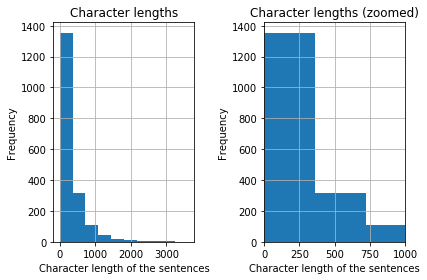

In [49]:
# Plot a histogram for that column
fig, axes = plt.subplots(1, 2)
df_cleaned.hist(column="length", ax=axes[0])
axes[0].set_title('Character lengths')
axes[0].set(xlabel="Character length of the sentences", ylabel="Frequency")

df_cleaned.hist(column="length", ax=axes[1])

axes[1].set_title('Character lengths (zoomed)')
axes[1].set(xlabel="Character length of the sentences", ylabel="Frequency", xlim = [0, 1000])
fig.tight_layout()

<br>
Define a cutoff for the sentences. All sentences belows this length will be removed

In [50]:
cut_len = 30

Create a smaller dataframe, and export it to csv, that only contains the short length sentences.
Check the csv and change the length condition accordingly.

In [51]:
# testing_df = df[df['length'] < cut_len]
# testing_df = testing_df.sort_values(by=['length'], ascending=False)

In [52]:
# testing_df.head(10)

In [53]:
# # Uncomment the following line of code to create the csv which contains the short length sentences.
# testing_df.to_csv(f"{year}_len_{cut_len}_testing.csv", index=False)

<br>
Once, the length is decided, update the dataframe with sentences greater that the length

In [54]:
# Initial length
ilen = df_cleaned.shape[0]

In [55]:
df_cleaned = df_cleaned[ df_cleaned["length"] > cut_len]
print("Length of the cleaned dataframe: ", df_cleaned.shape[0])
print("Reduction of about {:.2f}%".format( (1 - df_cleaned.shape[0]/ilen) * 100))

Length of the cleaned dataframe:  1359
Reduction of about 26.82%


In [56]:
df_cleaned.reset_index(drop=True, inplace=True)
df_cleaned.index.name = "index"

# Rearrange columns
cols = df_cleaned.columns.tolist()
cols = [cols[0]] + cols[-1:] + cols[1:-1]
df_cleaned = df_cleaned[cols]

In [57]:
df_cleaned

,org_sent,length,start_page,end_page,removed
index,,,,,
0,AN ACT TO GRANT TO THE CITY COUNCIL OF CHARLES...,179,35.0,35.0,344.
1,Be it enacted by the General Assembly of the S...,888,35.0,36.0,SECTION 1. ; SEc. 2.; - ; -
2,The grant herein made is upon the express cond...,287,36.0,36.0,-
3,That in case of the failure of the United Stat...,269,36.0,36.0,
4,That this Act shall take effect immediately up...,125,36.0,36.0,
...,...,...,...,...,...
1354,nds adjacent to said River; And whereas by the...,1780,291.0,291.0,- ; - ; - ; - ; - ; - ; - ; - ; la
1355,AN ACT TO EMPOWER AND AUTHORIZE THE COUNNTY BO...,193,291.0,292.0,"- ; Approved the 2oth day of February, A. D. 1..."
1356,Be it enacted by the General Assembly of the S...,817,292.0,292.0,SECTION 1. ; - ; - ; - ; -


<br>

## F. Adding features
The features added below are:
- an id: a concatenation of the year and index number
- whether the sentence is an Act or a Joint
- the state that the law originates from

<br>

### 1. Adding ID

In [58]:
def addPrefix(fileName: str, nameLen: int) -> str:
    '''
    Since the fileNames from the excel parsing could be any of any length
    (ranging from 1-3), this function appends a string of 0's to the 
    start of the input so that it is the specified nameLen lengths long.
    
    Parameters
    ----------
    fileName : str
        The file name that needs to be prefixed
        The fileName shouldn't have a prefix, such as '.tiff'
    nameLen : int
        The length of the expected name of the file
        Ex. '00034.jpg' would have length of 5
        so nameLen should be 5

    Returns
    -------
    str
        A length nameLen file name (prefixed with 0's)
    '''
    
    # prefix_length = nameLen - len(fileName)
    prefix = "0" * (nameLen - len(fileName))
    
    return prefix + fileName

In [59]:
df_cleaned.reset_index(inplace=True)
df_cleaned.rename(columns={"index" : "id"}, inplace=True)

In [60]:
# The length of the id of the last row in the dataframe, which is used to assess how many 0's will be prefixed to the other ids
maxNumLength = len(str(df_cleaned.last_valid_index()))

df_cleaned['id'] = df_cleaned.apply(lambda x: str(year) + "_" + addPrefix( str(x['id']), maxNumLength ), axis=1)

<br>

### 2. Adding the remaining identifiers

In [61]:
df_cleaned.insert(1, 'law_type', 'Acts')
df_cleaned.insert(2, 'state', 'SOUTH CAROLINA')

<br>

## Exporting

In [62]:
# Drop the 'removed' column
df_cleaned.drop(['removed'], axis = 1, inplace=True)

# Rename the 'org_sent' column
df_cleaned.rename(columns={"org_sent": "sentence"}, inplace=True)

df_cleaned

,id,law_type,state,sentence,length,start_page,end_page
0,1901_0000,Acts,SOUTH CAROLINA,AN ACT TO GRANT TO THE CITY COUNCIL OF CHARLES...,179,35.0,35.0
1,1901_0001,Acts,SOUTH CAROLINA,Be it enacted by the General Assembly of the S...,888,35.0,36.0
2,1901_0002,Acts,SOUTH CAROLINA,The grant herein made is upon the express cond...,287,36.0,36.0
3,1901_0003,Acts,SOUTH CAROLINA,That in case of the failure of the United Stat...,269,36.0,36.0
4,1901_0004,Acts,SOUTH CAROLINA,That this Act shall take effect immediately up...,125,36.0,36.0
...,...,...,...,...,...,...,...
1354,1901_1354,Acts,SOUTH CAROLINA,nds adjacent to said River; And whereas by the...,1780,291.0,291.0
1355,1901_1355,Acts,SOUTH CAROLINA,AN ACT TO EMPOWER AND AUTHORIZE THE COUNNTY BO...,193,291.0,292.0
1356,1901_1356,Acts,SOUTH CAROLINA,Be it enacted by the General Assembly of the S...,817,292.0,292.0
1357,1901_1357,Acts,SOUTH CAROLINA,That the proceeds of said levy of onehalf mill...,491,292.0,292.0


In [63]:
# # Export the final dataframe to csv for viewing
# df_cleaned.to_csv(f"{year}_faster.csv", index=False)